# IRIS

In this tutorial we will analyze the likelihood of a JPT fit on the IRIS dataset.
We will investigate the hyperparameters and their effects on parameter count and quality of JPTs.
Similar to the MNIST example we first have to join feature and targets.

In [1]:
import sklearn.datasets
import pandas as pd

dataset = sklearn.datasets.load_iris()
df = pd.DataFrame(columns=dataset.feature_names, data=dataset.data)

target = dataset.target.astype(object)
for idx, target_name in enumerate(dataset.target_names):
    target[target == idx] = target_name

df["plant"] = target


Next we define the variables and model.

In [2]:
import jpt.variables
import jpt.trees

variables = jpt.variables.infer_from_dataframe(df)

model = jpt.trees.JPT(variables, min_samples_leaf=30)

model.fit(df)

JPT
<DecisionNode #0 petal width (cm) = [petal width (cm) < 0.800; 0.800 ≤ petal width (cm)]; parent-#: None; #children: 2>
    <Leaf #1; parent: <DecisionNode #0>>
    <DecisionNode #2 petal length (cm) = [petal length (cm) < 5.150; 5.150 ≤ petal length (cm)]; parent-#: 0; #children: 2>
        <DecisionNode #3 sepal length (cm) = [sepal length (cm) < 5.850; 5.850 ≤ sepal length (cm)]; parent-#: 2; #children: 2>
            <Leaf #5; parent: <DecisionNode #3>>
            <Leaf #6; parent: <DecisionNode #3>>
        <Leaf #4; parent: <DecisionNode #2>>

JPT stats: #innernodes = 3, #leaves = 4 (7 total)

Let's have a look at the log likelihood.

In [3]:
import numpy as np

likelihood = model.likelihood(df)
log_likelihood = np.sum(np.log(likelihood))
log_likelihood

-348.57025395213486

Seems okay. Let's get a feeling for the likelihood with respect to the minimal samples per leaf.

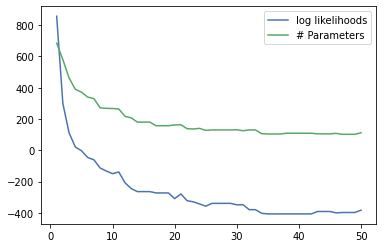

In [4]:
import matplotlib.pyplot as plt

log_likelihoods = np.zeros(50)
number_of_parameters = np.zeros(50)

for i in range(1,51):
    model = jpt.trees.JPT(variables, min_samples_leaf=i)
    model.fit(df)
    likelihood = model.likelihood(df)
    log_likelihoods[i-1] = np.sum(np.log(likelihood))
    number_of_parameters[i-1] = model.number_of_parameters()

plt.plot(range(1,51), log_likelihoods, label='log likelihoods')
plt.plot(range(1,51), number_of_parameters, label='# Parameters')
plt.legend()

In this plot we can observe multiple things. First of all, the more parameters we have, the more likelihood we get. Second, fewer samples per leaf produces more parameters which is also intuitive.
The spike that occurs when having few samples per leaf is explainable by the dirac delta. JPTs are able to use the dirac impulse as distribution when there is no uncertainty left in a leaf. The dirac impulse produces an infinite density. These densities are then scaled down, such that the likelihood remains measurable and comparable.
We can try to scale down that scaling.

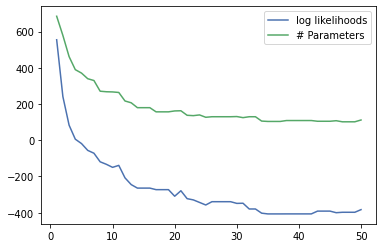

In [5]:
import matplotlib.pyplot as plt

log_likelihoods = np.zeros(50)
number_of_parameters = np.zeros(50)

for i in range(1,51):
    model = jpt.trees.JPT(variables, min_samples_leaf=i)
    model.fit(df)
    likelihood = model.likelihood(df, dirac_scaling=1.)
    log_likelihoods[i-1] = np.sum(np.log(likelihood))
    number_of_parameters[i-1] = model.number_of_parameters()

plt.plot(range(1,51), log_likelihoods, label='log likelihoods')
plt.plot(range(1,51), number_of_parameters, label='# Parameters')
plt.legend()

With the dirac_scaling keyword we can get a feeling for how many dirac impulses are represented in our model. Let's experiment with the min_impurity improvement parameter.

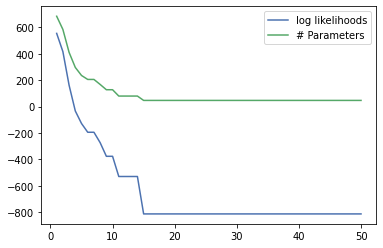

In [6]:
import matplotlib.pyplot as plt

log_likelihoods = np.zeros(50)
number_of_parameters = np.zeros(50)

for i in range(1,51):
    model = jpt.trees.JPT(variables, min_impurity_improvement=i*0.1)
    model.fit(df)
    likelihood = model.likelihood(df, dirac_scaling=1.)
    log_likelihoods[i-1] = np.sum(np.log(likelihood))
    number_of_parameters[i-1] = model.number_of_parameters()

plt.plot(range(1,51), log_likelihoods, label='log likelihoods')
plt.plot(range(1,51), number_of_parameters, label='# Parameters')
plt.legend()

This time we constrained the tree to only add new parameters when they improve the information gain significantly by at least min_impurity_improvement. The relations between the parameter count and likelihood remain the same. These two hyperparameters are influencing the training process the most.